In [ ]:
import os


In [ ]:
path = "/content/drive/MyDrive/Carbon_footprint_ml_model"
os.chdir(path)

In [ ]:
import pandas as pd


df = pd.read_csv("/content/drive/MyDrive/Carbon_footprint_ml_model/CarbonEmission.csv")  # Replace with actual filename


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


(7539, 65)
Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
                                 MSE  R² Score  Adjusted R²
Linear Regression       68371.645266  0.934240     0.932029
Ridge Regression        68360.472328  0.934250     0.932041
Lasso Regression        68307.696778  0.934301     0.932093
SVM Regression         139712.253722  0.865624     0.861107
Decision Tree          216170.965000  0.792085     0.785097
Decision Tree (Tuned)  163657.279636  0.842593     0.837303


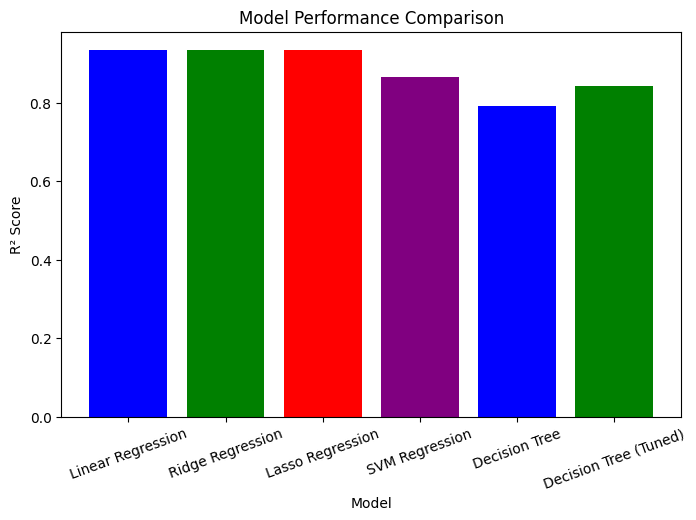

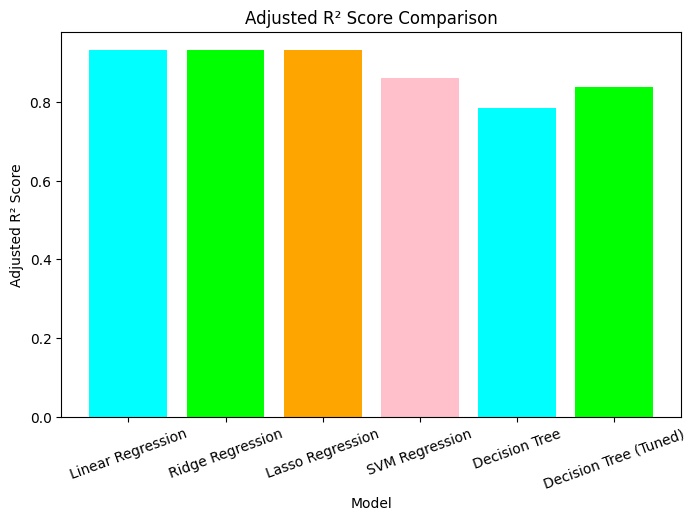

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor

# Load dataset (Upload file manually in Colab or mount Google Drive)
df = pd.read_csv('/content/drive/MyDrive/Carbon_footprint_ml_model/CarbonEmission.csv')

# Fix FutureWarning: Fill missing values in 'Vehicle Type' with mode
df['Vehicle Type'] = df['Vehicle Type'].fillna(df['Vehicle Type'].mode()[0])

# Define the target variable
target = 'CarbonEmission'
X = df.drop(columns=[target])
y = df[target]

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# One-hot encode categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_encoded = encoder.fit_transform(X[categorical_cols])
X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[numerical_cols])
X_scaled_df = pd.DataFrame(X_scaled, columns=numerical_cols)

# Combine processed features
X_final = pd.concat([X_scaled_df, X_encoded_df], axis=1)

# Add constant for regression analysis
X_with_const = sm.add_constant(X_final)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Fit OLS model on training set only
X_train_const = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_const).fit()

# Compute Cook's Distance
cooks_d = model.get_influence().cooks_distance[0]
threshold_cooks = 4 / len(X_train_const)
influential_points = np.where(cooks_d > threshold_cooks)[0]

# Identify influential points in the training set only
train_indices = X_train.index  # Get the original indices of training data
influential_train_points = np.intersect1d(influential_points, train_indices)

# Remove only influential points from the training set
X_train_cleaned = X_train.drop(index=influential_train_points).reset_index(drop=True)
y_train_cleaned = y_train.drop(index=influential_train_points).reset_index(drop=True)

print(X_train_cleaned.shape)
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=0.46415888336127775),
    'Lasso Regression': Lasso(alpha=0.1),
    'SVM Regression': SVR(kernel='linear'),
    'Decision Tree': DecisionTreeRegressor()
}
# Define parameter grid for Decision Tree
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid,
                           cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print("Best parameters for Decision Tree:", best_params)

# Train Decision Tree with best parameters
best_dt = DecisionTreeRegressor(**best_params, random_state=42)
best_dt.fit(X_train, y_train)

# Add the tuned Decision Tree model
models['Decision Tree (Tuned)'] = best_dt
# Train and evaluate models
results = {}
n = len(y_test)  # Number of observations in test set
p = X_test.shape[1]  # Number of predictors (features)

for name, model in models.items():
    model.fit(X_train_cleaned, y_train_cleaned)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))  # Adjusted R²

    results[name] = {"MSE": mse, "R² Score": r2, "Adjusted R²": adj_r2}

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

# Visualize model performance
plt.figure(figsize=(8,5))
plt.bar(results_df.index, results_df['R² Score'], color=['blue', 'green', 'red', 'purple'])
plt.xlabel("Model")
plt.ylabel("R² Score")
plt.title("Model Performance Comparison")
plt.xticks(rotation=20)
plt.show()

# Visualize Adjusted R²
plt.figure(figsize=(8,5))
plt.bar(results_df.index, results_df['Adjusted R²'], color=['cyan', 'lime', 'orange', 'pink'])
plt.xlabel("Model")
plt.ylabel("Adjusted R² Score")
plt.title("Adjusted R² Score Comparison")
plt.xticks(rotation=20)
plt.show()

In [5]:
import joblib

# Train Lasso Regression model
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train_cleaned, y_train_cleaned)

# Save the model as a .pkl file
lasso_model_path = "/content/drive/MyDrive/Carbon_footprint_ml_model/lasso_model.pkl"
joblib.dump(lasso_model, lasso_model_path)

print(f"Lasso Regression model saved at: {lasso_model_path}")


Lasso Regression model saved at: /content/drive/MyDrive/Carbon_footprint_ml_model/lasso_model.pkl


In [20]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Ridge and Lasso Regression
param_grid = {'alpha': np.logspace(-3, 3, 10)}  # Testing alpha values from 0.001 to 1000

# GridSearchCV for Ridge Regression
ridge = Ridge()
ridge_cv = GridSearchCV(ridge, param_grid, cv=5, scoring='r2', n_jobs=-1)
ridge_cv.fit(X_train_cleaned, y_train_cleaned)

print(f"Best alpha for Ridge: {ridge_cv.best_params_}")


# GridSearchCV for Lasso Regression
lasso = Lasso()
lasso_cv = GridSearchCV(lasso, param_grid, cv=5, scoring='r2', n_jobs=-1)
lasso_cv.fit(X_train_cleaned, y_train_cleaned)

print(f"Best alpha for Lasso: {lasso_cv.best_params_}")



Best alpha for Ridge: {'alpha': np.float64(0.46415888336127775)}
Best alpha for Lasso: {'alpha': np.float64(0.1)}


In [7]:
import joblib
import

# Save the best Ridge and Lasso models
joblib.dump(ridge_cv.best_estimator_, 'ridge_best_model.pkl')
joblib.dump(lasso_cv.best_estimator_, 'lasso_best_model.pkl')

print("Models saved successfully!")


Models saved successfully!


In [14]:
import joblib

# Load the saved model
loaded_model = joblib.load('/content/drive/MyDrive/Carbon_footprint_ml_model/lasso_best_model.pkl')

# Select a sample row from X_test
sample_index = 79 # Choose the second row (index 1)
new_sample = X_test.iloc[sample_index]
actual_value = y_test.iloc[sample_index]  # Get actual Carbon Emission

# Predict the Carbon Emission
new_prediction = loaded_model.predict([new_sample])[0]

# Print actual and predicted values
print("Actual Carbon Emission:", actual_value)
print("Predicted Carbon Emission:", new_prediction)


Actual Carbon Emission: 2126
Predicted Carbon Emission: 2185.147850171891


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


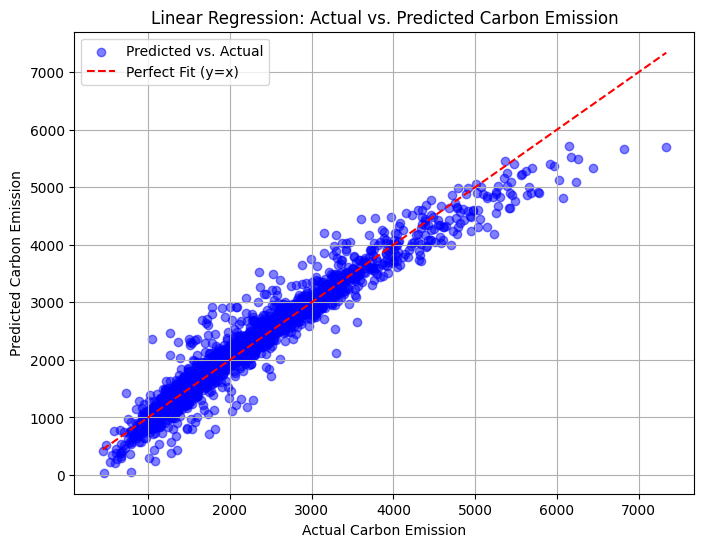

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Get predictions for all test samples
y_pred = loaded_model.predict(X_test)

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label="Predicted vs. Actual", alpha=0.5)

# Plot the perfect prediction line (y = x)
x_line = np.linspace(min(y_test), max(y_test), 100)
plt.plot(x_line, x_line, color='red', linestyle='dashed', label="Perfect Fit (y=x)")

# Labels and title
plt.xlabel("Actual Carbon Emission")
plt.ylabel("Predicted Carbon Emission")
plt.title("Linear Regression: Actual vs. Predicted Carbon Emission")
plt.legend()
plt.grid(True)
plt.show()
